In [1]:
import os
import numpy as np

%load_ext autoreload
%autoreload 2

#display all the results not only the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from node_embeddings.graphs.Undirected_Graph import Undirected_Graph
from node_embeddings.models.Undirected_MSM import Undirected_MSM
# from node_embeddings.plots.plotting_functions import *
from node_embeddings.utils import dataset_loader as ds

dataset_name = "Gleditsch"
distance_matrix, lvl_to_nclust = None, None

# note that inside the kwargs there is a copy of the pdtrans
id_code, cg_method, year = ds.default_4_undirected_paper(dataset_name)
print(f'-id_code, cg_method, year: {id_code, cg_method, year}',)
pdtrans, kwargs, total_levels = ds.dataset_loader(dataset_name, id_code = id_code, cg_method = cg_method, year = year)

pdtrans.head()

-id_code, cg_method, year: ('int', 'geo-dist', 2000)

Reading from local source @ ./data/Gleditsch-2000-Undirected/edges_int_pd.csv


,payer_int,beneficiary_int,amount_euro
0,0,4,3.500
1,0,5,0.032
2,0,8,1.048
3,0,9,1.000
4,0,10,1.000


Find the level, up to which the network is not fully connected. No reason to fit a probabilistic model on a complete/empty graphs, since they are fully deterministic.

In [2]:
for level in np.arange(total_levels):
    
    # update only the level
    kwargs.update({"level" : level,})
    
    # create the Undirected Graph
    net = Undirected_Graph(**kwargs)

    # the network is complete when all the entries of the adj mat are ones
    if net.bin_adj.sum() == net.bin_adj.size:
        total_levels = level

print(f'-Effective total_levels: {total_levels}',)

-Effective total_levels: 6


Fix the hyper-parameters for the model

In [3]:
# for multi_models use maxlMSM.dimX > 1 or LPCA
model_objective = "NodeEmb"
model_name = "MSM"
dimX =        2
initial_guess, seed = "random", 0
loss_iters, n_epochs = int(1e3), 20
level = 0

In [ ]:
for level in [0, 1]:
    print(f'\n-Level: {level} for {model_name} - dim {dimX}',)
    kwargs.update({"level" : level,})
    net = Undirected_Graph(**kwargs)

    und_density = 2 * net.n_edges / (net.n_nodes * (net.n_nodes - 1))
    print(f'-net.n_nodes, net.n_edges, und_density: {net.n_nodes}, {net.n_edges}, {und_density:.4}',)

    # don't fit if complete graph or empty
    if net.n_nodes - net.fc_nodes.size > 0 and ~np.any(net.deg == 0):
        model_kwargs = {
                        "name" : model_name,
                        "dimX" : dimX,
                        "dimBCX" :dimX,
                        # "pdtrans" : net.pdtrans,
                        "initial_guess" : initial_guess,
                        "seed" : seed,
                        "direction" : "Undirected",
                        "objective" : model_objective,
                    }

        fit_model = Undirected_MSM(obs_net = net, **model_kwargs)
        A = fit_model.zl_notdet_A if fit_model.get("reduced_by") == "neigh" else net.zl_bin_adj    
        fit_model._set_initial_guess()
        fit_model.fit(A, loss_iters, n_epochs,)


-Level: 0 for MSM - dim 2
-net.n_nodes, net.n_edges, und_density: 182, 9993, 0.6067


-Optimization tnc epoch:  40%|████      | 8/20 [00:07<00:11,  1.08it/s]


Plot the expected degrees of the last level

[None,
 None,
 Text(0.5, 0, 'Observed net.deg'),
 Text(0, 0.5, 'Expected fit_model.deg'),
 Text(0.5, 1.0, 'Expected VS Observed Level 1')]

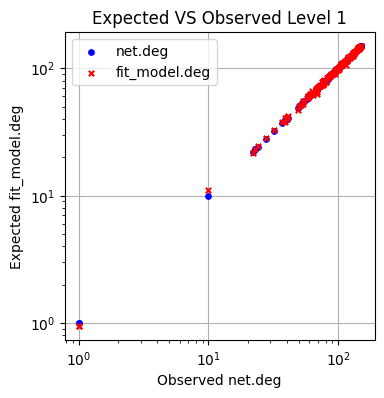

In [ ]:
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize = (4,4))
axis_scale = 'log'
obs_s, exp_s = 15, 15
ax.scatter(net.deg,net.deg, marker = 'o', color = 'b', s = obs_s, label = 'net.deg')
ax.scatter(net.deg,fit_model.deg, marker = 'x', color = 'r', s = exp_s, label = 'fit_model.deg')
ax.set(xscale = axis_scale, yscale = axis_scale, xlabel = 'Observed net.deg', ylabel = 'Expected fit_model.deg', title = f'Expected VS Observed Level {level}')
ax.legend()
ax.set_axisbelow(True)
ax.grid(True)
